 MoViNets are video classification models used for streaming video or online inference in tasks, such as action recognition. A 2D frame based classifier is efficient and simple to run over whole videos, or streaming one frame at a time. Because they can't take temporal context into account they have limited accuracy and may give inconsistent outputs from frame to frame.

A simple 3D CNN uses bidirectional temporal context which can increase accuracy and temporal consistency. These networks may require more resources and because they look into the future they can't be used for streaming data.

In [56]:
# pip install remotezip

In [57]:
# pip install seaborn

In [58]:
# pip install tensorflow_hub

In [59]:
# pip install itertools

In [60]:
# pip install tf-models-official

In [61]:
# !pip install -U -q "tf-models-official"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import remotezip as rz
import seaborn as sns

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
import tqdm
import random
import pathlib
import itertools
import collections

from moviepy.editor import VideoFileClip


In [9]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import os
os.chdir('/content/gdrive/MyDrive/CV')

In [3]:
classes = ['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift',
                 'decline bench press', 'hip thrust', 'incline bench press',
                 'lat pulldown', 'lateral raise', 'leg extension', 'leg raises',
                 'pull up', 'push-up', 'romanian deadlift', 'russian twist', 'shoulder press',
                 'squat', 't bar row', 'tricep dips', 'tricep pushdown']

In [5]:
import os
path = 'C:\\Users\\LEGION\\Desktop\\DATA SCIENCE - studia\\Moje projekty\\dataset'
# path = 'dataset'

file_paths = []
files_for_class = collections.defaultdict(list)

for name in classes:
    class_path = os.path.join(path, name)
    file_count = len(os.listdir(class_path))
    for i in range(file_count):
        name_i = name + '_' + str(i+1) + '.mp4'
        file_path = os.path.join(class_path, name_i)
        files_for_class[name].append(file_path)
        file_paths.append(file_path)

In [6]:
print('Num videos for class[0]:', len(files_for_class[classes[0]]))
print('Num videos for class', [len(files_for_class[classes[i]]) for i in range(len(classes))])
print('Min num videos for class', min([len(files_for_class[classes[i]]) for i in range(len(classes))]))

Num videos for class[0]: 62
Num videos for class [62, 61, 28, 32, 13, 18, 33, 51, 37, 25, 21, 26, 56, 14, 13, 17, 30, 22, 21, 50]
Min num videos for class 13


In [7]:
NUM_CLASSES = len(classes)
FILES_PER_CLASS = 30

In [8]:
NUM_CLASSES

20

In [9]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  train_subset = dict()
  test_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    train_subset[class_name] = class_files[:files_per_class]
    if class_files[files_per_class:]:
        test_subset[class_name] = class_files[files_per_class:]
  return train_subset, test_subset

In [10]:
train_subset, test_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(train_subset.keys())

['barbell biceps curl',
 'bench press',
 'chest fly machine',
 'deadlift',
 'decline bench press',
 'hip thrust',
 'incline bench press',
 'lat pulldown',
 'lateral raise',
 'leg extension',
 'leg raises',
 'pull up',
 'push-up',
 'romanian deadlift',
 'russian twist',
 'shoulder press',
 'squat',
 't bar row',
 'tricep dips',
 'tricep pushdown']

In [11]:
list(test_subset.keys())

['barbell biceps curl',
 'bench press',
 'deadlift',
 'incline bench press',
 'lat pulldown',
 'lateral raise',
 'push-up',
 'tricep pushdown']

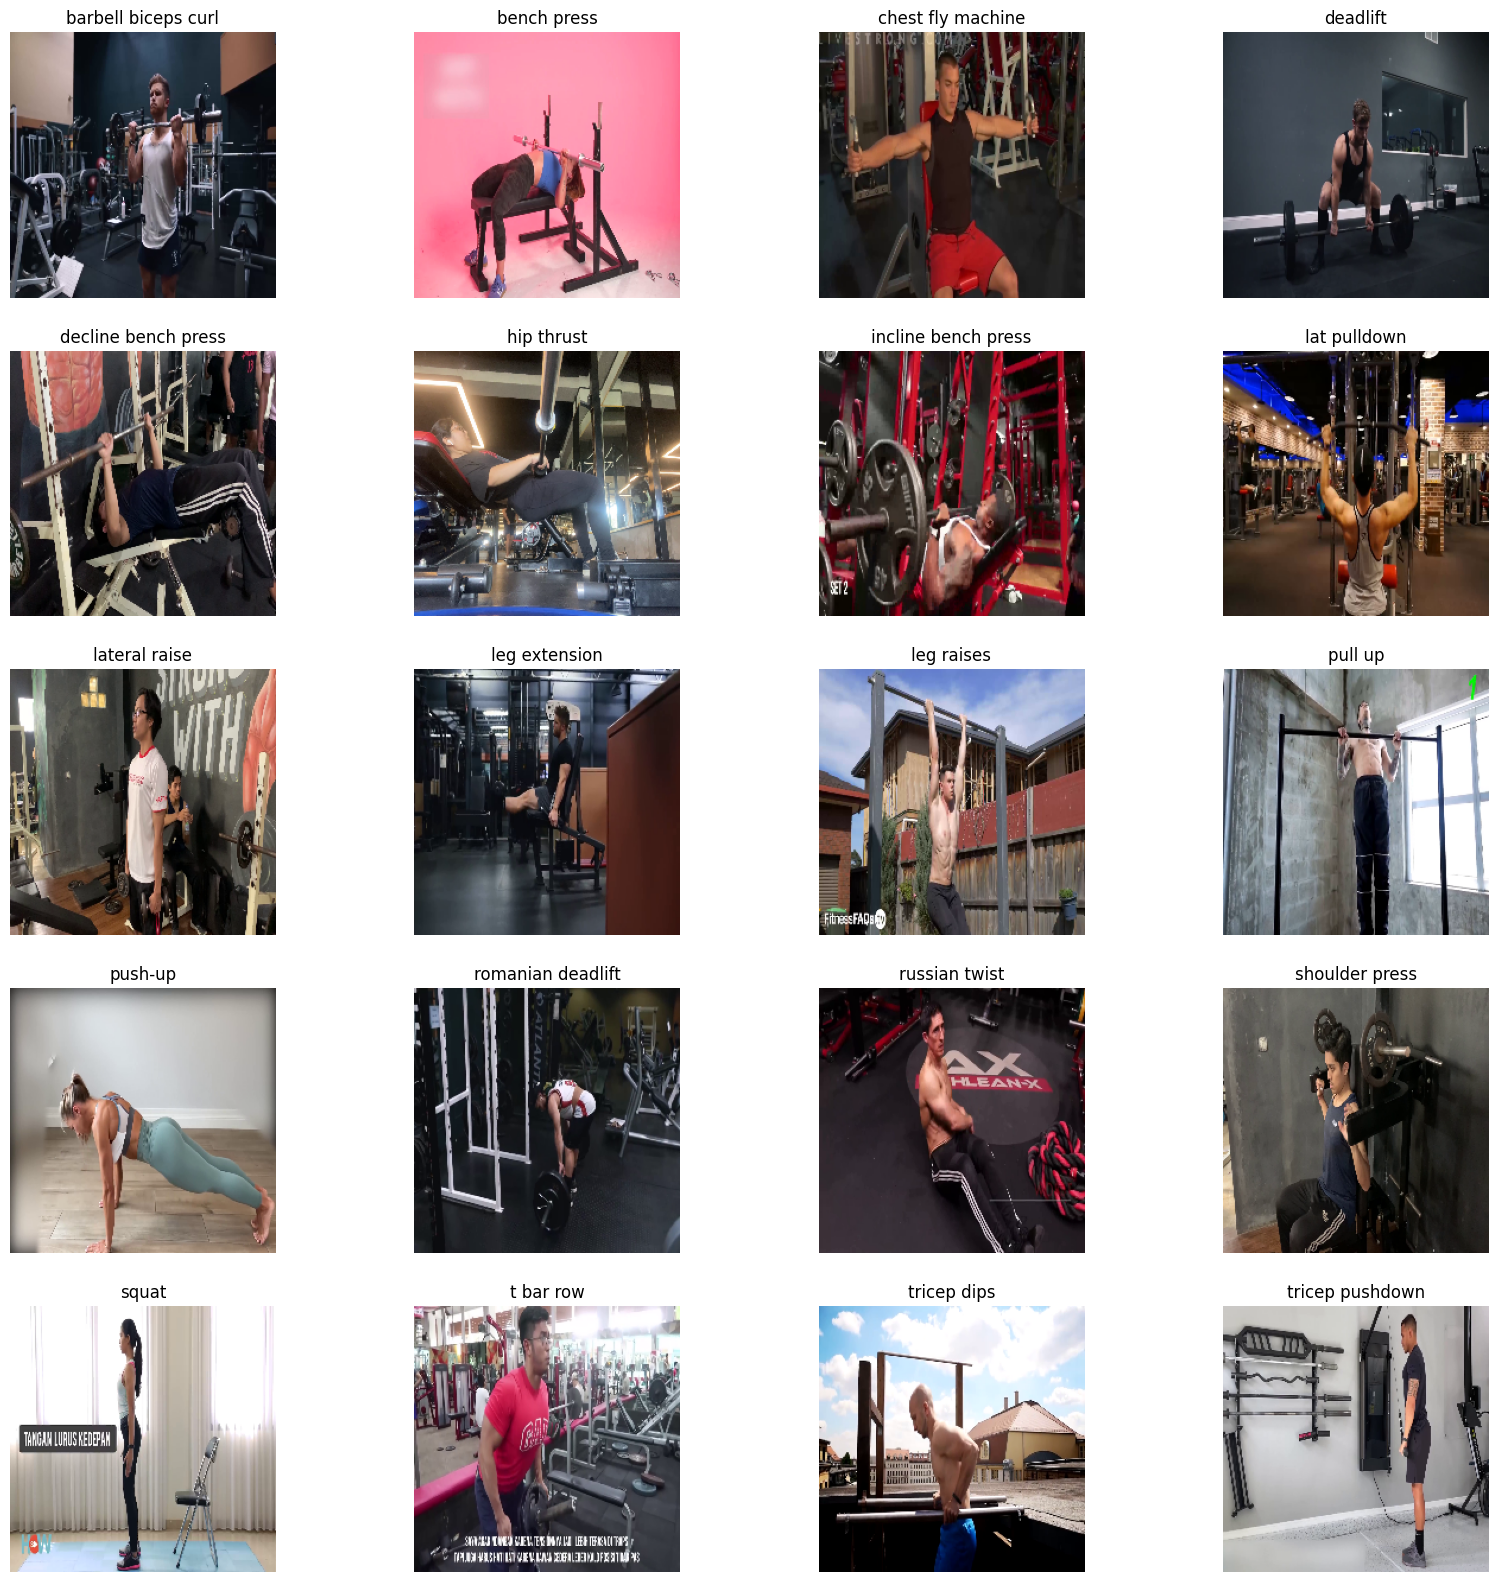

In [13]:
plt.figure(figsize = (20, 20))

for counter, random_index in enumerate(range(len(classes)), 1):

    selected_class_Name = classes[random_index]
    video_files_path_list = train_subset[selected_class_Name]

    selected_video_file_path = random.choice(video_files_path_list)
    video_reader = cv2.VideoCapture(selected_video_file_path)
    video_reader.set(1, 25)

    _, frame = video_reader.read()

    frame = cv2.resize(frame,(224,224))

    video_reader.release()

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 4, counter)
    plt.imshow(frame)
    plt.title(selected_class_Name)
    plt.axis('off')

In [22]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30

In [23]:
def frames_extraction(video_path):
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [24]:
def create_dataset(subset):
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(classes):
        if class_name not in subset.keys():
            continue

        print(f'Extracting Data of Class: {class_name}')
        files_list = subset[class_name]
        for video_file_path in files_list:

            frames = frames_extraction(video_file_path)
            frames = frames[:SEQUENCE_LENGTH]
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [25]:
features, labels, video_files_paths = create_dataset(train_subset)

Extracting Data of Class: barbell biceps curl
Extracting Data of Class: bench press
Extracting Data of Class: chest fly machine
Extracting Data of Class: deadlift
Extracting Data of Class: decline bench press
Extracting Data of Class: hip thrust
Extracting Data of Class: incline bench press
Extracting Data of Class: lat pulldown
Extracting Data of Class: lateral raise
Extracting Data of Class: leg extension
Extracting Data of Class: leg raises
Extracting Data of Class: pull up
Extracting Data of Class: push-up
Extracting Data of Class: romanian deadlift
Extracting Data of Class: russian twist
Extracting Data of Class: shoulder press
Extracting Data of Class: squat
Extracting Data of Class: t bar row
Extracting Data of Class: tricep dips
Extracting Data of Class: tricep pushdown


In [26]:
features_test, labels_test, test_files_paths = create_dataset(test_subset)

Extracting Data of Class: barbell biceps curl
Extracting Data of Class: bench press
Extracting Data of Class: deadlift
Extracting Data of Class: incline bench press
Extracting Data of Class: lat pulldown
Extracting Data of Class: lateral raise
Extracting Data of Class: push-up
Extracting Data of Class: tricep pushdown


In [ ]:
from keras.utils import to_categorical

labels = to_categorical(labels)

In [ ]:
labels_test = to_categorical(labels_test)

In [ ]:
features.shape

(478, 30, 64, 64, 3)

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((features, labels))
test_ds = tf.data.Dataset.from_tensor_slices((features_test, labels_test))

batch_size = 8

train_ds = train_ds.shuffle(buffer_size=len(labels)).batch(batch_size)
test_ds = test_ds.shuffle(buffer_size=len(labels)).batch(batch_size)

In [28]:
for features_batch, labels_batch in train_ds.take(3):
    print("Features Shape:", features_batch.shape)
    print("Labels Shape:", labels_batch.shape)
    # print(labels_batch)

Features Shape: (8, 30, 64, 64, 3)
Labels Shape: (8,)
Features Shape: (8, 30, 64, 64, 3)
Labels Shape: (8,)
Features Shape: (8, 30, 64, 64, 3)
Labels Shape: (8,)


In [29]:
for features_batch, labels_batch in test_ds.take(3):
    print("Features Shape:", features_batch.shape)
    print("Labels Shape:", labels_batch.shape)
    # print(labels_batch)

Features Shape: (8, 30, 64, 64, 3)
Labels Shape: (8,)
Features Shape: (8, 30, 64, 64, 3)
Labels Shape: (8,)
Features Shape: (8, 30, 64, 64, 3)
Labels Shape: (8,)


In [ ]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

history_fine = model.fit(train_ds,
          epochs = 30,
          validation_data = test_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

Epoch 1/30
60/60 [==============================] - 56s 695ms/step - loss: 2.9549 - accuracy: 0.1757 - val_loss: 2.9162 - val_accuracy: 0.2394
Epoch 2/30
60/60 [==============================] - 37s 616ms/step - loss: 2.8164 - accuracy: 0.4017 - val_loss: 2.8711 - val_accuracy: 0.2817
Epoch 3/30
60/60 [==============================] - 36s 609ms/step - loss: 2.6964 - accuracy: 0.5983 - val_loss: 2.8357 - val_accuracy: 0.3380
Epoch 4/30
60/60 [==============================] - 35s 589ms/step - loss: 2.6112 - accuracy: 0.6736 - val_loss: 2.8323 - val_accuracy: 0.3310
Epoch 5/30
60/60 [==============================] - 35s 588ms/step - loss: 2.5565 - accuracy: 0.7029 - val_loss: 2.8319 - val_accuracy: 0.3028
Epoch 6/30
60/60 [==============================] - 34s 565ms/step - loss: 2.5155 - accuracy: 0.7322 - val_loss: 2.8252 - val_accuracy: 0.3239
Epoch 7/30
60/60 [==============================] - 40s 662ms/step - loss: 2.4804 - accuracy: 0.7678 - val_loss: 2.8119 - val_accuracy: 0.3451

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

In [ ]:
val_loss

[2.916220188140869,
 2.871077299118042,
 2.835690975189209,
 2.8322818279266357,
 2.8318753242492676,
 2.8252294063568115,
 2.81191086769104,
 2.807901620864868,
 2.8137617111206055,
 2.806830883026123,
 2.809086322784424,
 2.8096044063568115]

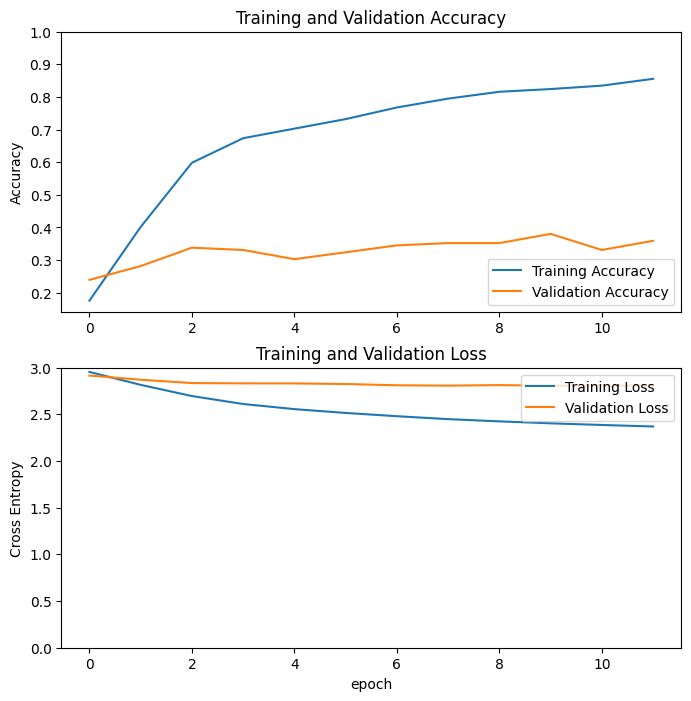

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [41]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [42]:
model = build_classifier(batch_size, SEQUENCE_LENGTH, resolution, backbone, 20)

In [43]:
num_epochs = 20

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])


In [44]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1,
                    callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

Epoch 1/20
60/60 [==============================] - 51s 544ms/step - loss: 2.4312 - accuracy: 0.3075 - val_loss: 2.3913 - val_accuracy: 0.2958
Epoch 2/20
60/60 [==============================] - 6s 91ms/step - loss: 1.2506 - accuracy: 0.6653 - val_loss: 2.3554 - val_accuracy: 0.3873
Epoch 3/20
60/60 [==============================] - 4s 64ms/step - loss: 0.6897 - accuracy: 0.8326 - val_loss: 2.7445 - val_accuracy: 0.3803
Epoch 4/20
60/60 [==============================] - 6s 94ms/step - loss: 0.3994 - accuracy: 0.9184 - val_loss: 2.8830 - val_accuracy: 0.3873


In [45]:
model.evaluate(test_ds, return_dict=True)


18/18 [==============================] - 1s 56ms/step - loss: 2.8830 - accuracy: 0.3873


{'loss': 2.883016347885132, 'accuracy': 0.38732394576072693}

In [41]:
def get_actual_predicted_labels(dataset):
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [43]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [55]:
actual, predicted = get_actual_predicted_labels(test_ds)

In [70]:
predicted

<tf.Tensor: shape=(142,), dtype=int64, numpy=
array([19, 12,  1, 10, 19,  8,  0, 12,  8,  6,  0, 10, 12, 12, 12,  6, 12,
        9, 12, 17, 19,  9, 19,  0,  1,  6, 19, 19,  9,  2,  9, 12, 15,  1,
        9, 12, 15,  1,  8, 16,  0,  0,  1,  1,  3, 15,  7, 19,  6, 19,  6,
        8, 19,  3, 19,  6,  9, 19, 12, 19,  8,  1, 19,  0,  9, 12, 12,  0,
       12, 16,  1,  6,  9,  6,  3,  6,  3, 14, 19,  0,  6,  9,  0,  0,  1,
        0, 11,  6,  2,  5,  7, 11,  0, 15,  8,  6,  0,  8, 12, 18, 17, 12,
        3,  6, 19,  6, 12,  0, 15, 19,  6, 15,  8, 19,  6,  9,  1, 19,  8,
        6, 19,  1, 10, 14,  6,  1,  0,  3,  9,  9,  6, 12,  6,  0, 19,  7,
       18, 19,  9,  6,  9, 14])>

In [72]:
actual

<tf.Tensor: shape=(142,), dtype=int64, numpy=
array([19,  8, 12, 19, 19,  1,  0, 19,  1,  0,  8, 19,  0,  0,  1,  8, 12,
        1,  1,  0,  0,  3,  1,  3,  7, 12,  0,  1,  0,  0,  1,  0,  7,  0,
       12,  7,  7, 12, 19, 12, 12, 19, 19, 19,  1,  0, 19,  0,  8,  1,  1,
       12,  1,  1,  1,  7,  1,  7,  6,  7,  1, 12,  6,  1, 19,  1, 12,  0,
       12,  0,  7,  6,  0,  1,  7, 12,  0,  1,  1,  0,  7, 12, 12,  7,  1,
        0,  1, 12, 19,  0,  1, 12, 12,  0,  7, 19, 12, 19,  0,  1,  1,  0,
       12,  7,  7, 12, 12,  0,  8,  7,  7, 19,  1, 12, 19,  0,  8,  7,  0,
        8, 19, 19,  1,  0,  7,  7, 19, 12,  1,  7, 12,  0,  1,  1,  7,  0,
        0, 12,  0,  0, 19, 12])>

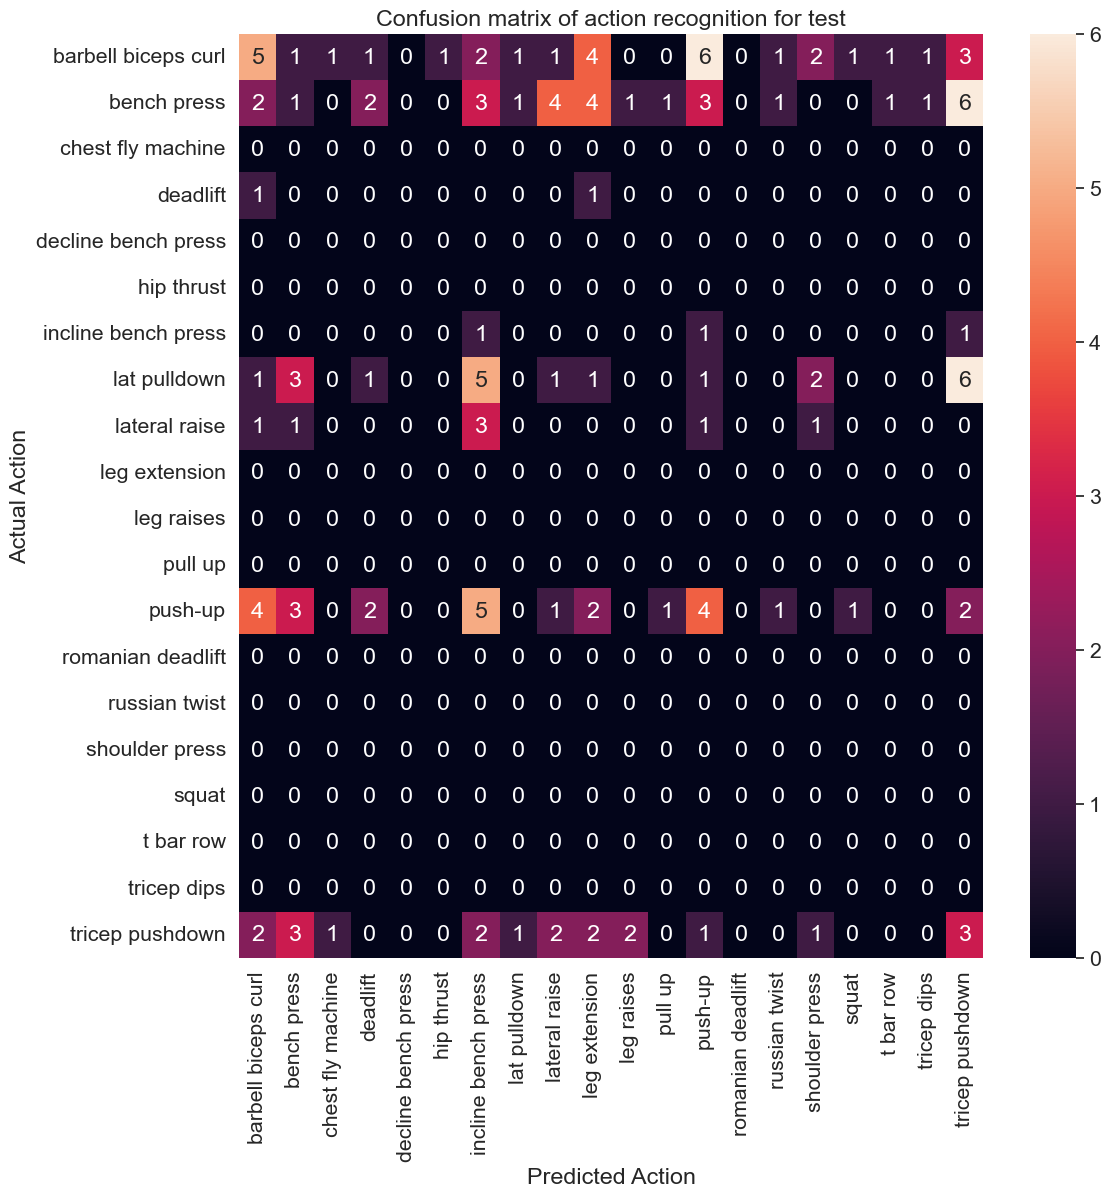

In [50]:
plot_confusion_matrix(actual, predicted, classes, 'test')

In [47]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

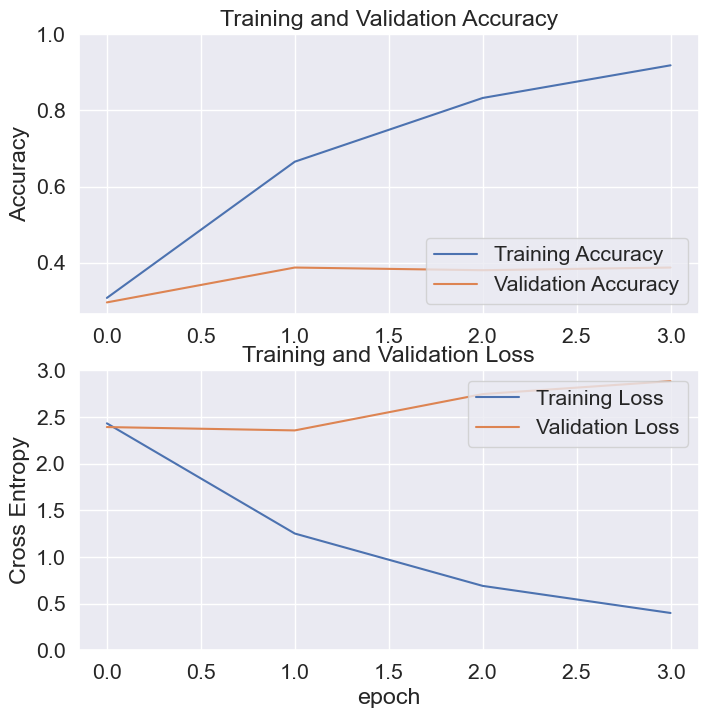

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()